In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
import utils
from model import DSFANet

In [5]:
def main(X, Y, GT, diff):

    train_num = 2000
    max_iters = 2000
    lr = 1e-4

    index = np.argsort(diff)
    XData = X[index[0:train_num], :]
    YData = Y[index[0:train_num], :]

    inputX = tf.keras.Input(dtype=tf.dtypes.float32, shape=[None, X.shape[-1]])
    inputY = tf.keras.Input(dtype=tf.dtypes.float32, shape=[None, Y.shape[-1]])

    model = DSFANet(num=train_num)
    loss = model.forward(X=inputX, Y=inputY)

    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()

    gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
    conf = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    sess = tf.compat.v1.Session(config=conf)

    sess.run(init)

    train_loss = np.zeros(max_iters)

    for k in range(max_iters):

        _, train_loss[k] = sess.run([optimizer, loss], feed_dict={inputX: XData, inputY: YData})

        if k % 100 == 0:
            print('iter %4d, loss is %.4f' % (k, train_loss[k]))

    XTest, YTest = sess.run([model.X_, model.Y_], feed_dict={inputX: X, inputY: Y})

    sess.close()

    X_trans, Y_trans = utils.SFA(XTest, YTest)

    diff = X_trans-Y_trans
    diff = diff / np.std(diff, axis=0)

    plt.imsave('DSFAdiff.png', (diff**2).sum(axis=1).reshape(GT.shape), cmap='gray')

    bin = KMeans(n_clusters=2).fit((diff**2).sum(axis=-1, keepdims=True)).labels_
    #bin = KMeans(n_clusters=2).fit(diff).labels_
    plt.imsave('DSFACD.png', bin.reshape(GT.shape), cmap='gray')
    #diff = abs(diff)
    #plt.imsave('DSFAcolor.png',(diff/diff.max()).reshape(GT.shape[0], GT.shape[1],3))

    print(accuracy_score(GT.reshape(-1, 1)/255, bin))
    print(accuracy_score(GT.reshape(-1, 1)/255, 1-bin))

    return True


In [6]:
if __name__ == '__main__':
    
    X, Y, GT = utils.load_dataset()
    diff = utils.cva(X=X, Y=Y)
    plt.imsave('cva_diff.png', np.reshape(diff, GT.shape), cmap='gray')
    main(X, Y, GT, diff)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

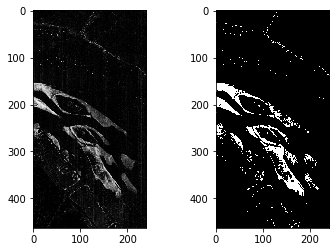

In [5]:
DSFAdiff = plt.imread('DSFAdiff.png')
DSFACD = plt.imread('DSFACD.png')
plt.subplot('121')
plt.imshow(DSFAdiff)
plt.subplot('122')
plt.imshow(DSFACD)
plt.show()